# Simulación del benchmark Godiva con `OpenMC`

## Objetivo

El objetivo de este notebook es realizar un benchmark del reactor Godiva. Godiva es una esfera de $8.7407$ cm de radio de uranio metálico de densidad $18.74$ gm/cm$^3$, $93.71$ % en peso de $^{235}U$, $5.27$ % en peso de $^{238}U$, y $1.02$ % en peso de $^{234}U$.

## Ayuda

Importación de las distintas bibliotecas necesarias para los códigos y la biblioteca de secciones eficaces necesarias para los cálculos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import openmc
import os

In [ ]:
openmc_data = "/Users/gregoire_lebreton/anaconda3/envs/internship/endfb71_hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

## Materiales

Creación del material de la esfera con los diferentes isótopos de uranio y su título de masa y definición de la densidad del material de la esfera.

In [2]:
mat01 = openmc.Material(material_id = 1)
mat01.add_nuclide("U235", 0.9371, 'wo')
mat01.add_nuclide("U238", 0.0527, 'wo')
mat01.add_nuclide("U234", 0.0102, 'wo')
mat01.set_density("g/cm3", 18.74)

## Geometría

Definición de la geometría que es una esfera de radio R0=8,7407cm con Uranio en el interior y vacío en el exterior.

In [3]:
R01 = 8.7407

surf01 = openmc.Sphere(r = R01, boundary_type = "vacuum", surface_id = 1)
cell01 = openmc.Cell(region = -surf01, fill = mat01, cell_id = 1)
univ01 = openmc.Universe(cells = [cell01], universe_id = 1)

#univ01.plot(width = (2*R01, 2*R01))

## Parámetros

Definición de los distintos parámetros y del modo de funcionamiento "eigenvalue".

In [20]:
sets = openmc.Settings()
sets.run_mode = "eigenvalue"
sets.particles = 100
sets.batches = 110
sets.inactive = 10
sets.photon_transport = True

## Tallies

Definición de las distintas grillas, filtros y tallies útiles.

In [21]:
tallies = openmc.Tallies()

In [22]:
#space 
mesh = openmc.RegularMesh(mesh_id=1)

mesh.dimension = [100, 100, 1]
mesh.lower_left = [-R01,-R01,-R01]
mesh.upper_right = [R01,R01,R01]
meshsurface_filter = openmc.MeshSurfaceFilter(mesh)
mesh_filter = openmc.MeshFilter(mesh)

/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


In [23]:
#energy 
energy_n=np.logspace(np.log10(1e-5), np.log10(1e7), 201)
energy_p=np.linspace(0,20e6,201)
energy_filter_neutron = openmc.EnergyFilter(energy_n,filter_id=2)
energy_filter_photon = openmc.EnergyFilter(energy_p,filter_id=3)

/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)


In [24]:
#particule
particle_filter_neutron=openmc.ParticleFilter('neutron', filter_id=4)
particle_filter_photon=openmc.ParticleFilter('photon', filter_id=5)


/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=4.
  warn(msg, IDWarning)
/Users/gregoire_lebreton/anaconda3/envs/internship/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=5.
  warn(msg, IDWarning)


In [25]:
#neutron,position
tally = openmc.Tally(name='flux_n_position')
tally.filters=[mesh_filter,particle_filter_neutron]
tally.scores = ['flux']
tallies.append(tally)

In [26]:
#photon,position
tally = openmc.Tally(name='flux_p_position')
tally.filters=[mesh_filter,particle_filter_photon]
tally.scores = ['flux']
tallies.append(tally)

In [27]:
#neutron,energy
tally = openmc.Tally(name='flux_n_energy')
tally.filters=[energy_filter_neutron,particle_filter_neutron]
tally.scores = ['flux']
tallies.append(tally)

In [28]:
#photon,energy 
tally = openmc.Tally(name='flux_p_energy')
tally.filters=[energy_filter_photon,particle_filter_photon]
tally.scores = ['flux']
tallies.append(tally)

In [29]:
leak = openmc.Tally(name='leakage')
leak.filters = [meshsurface_filter]
leak.scores = ['current']
tallies.append(leak)

In [30]:
fiss_rate = openmc.Tally(name='fiss. rate')
abs_rate = openmc.Tally(name='abs. rate')
fiss_rate.scores = ['nu-fission']
abs_rate.scores = ['absorption']
tallies += (fiss_rate, abs_rate)

## Generación de los archivos `.xml`

In [31]:
geom = openmc.Geometry(univ01)
geom.export_to_xml()
mats = openmc.Materials(geom.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()
sets.export_to_xml()

In [32]:
tallies.export_to_xml()

In [33]:
!rm statepoint.110.h5
!rm summary.h5
openmc.run()

rm: statepoint.110.h5: No such file or directory


rm: summary.h5: No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%

## Tratamiento de datos

In [34]:
sp= openmc.StatePoint('statepoint.110.h5') 

In [35]:
flux_n_position=sp.get_tally(name='flux_n_position')
print(flux_n_position)

Tally
	ID             =	8
	Name           =	flux_n_position
	Filters        =	MeshFilter, ParticleFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength


In [36]:
flux_n_position.mean.shape

(10000, 1, 1)

In [37]:
flux_n_position.std_dev.shape = (100, 100)
flux_n_position.mean.shape = (100, 100)

Text(0.5, 1.0, 'Distribución del flujo de neutrones')

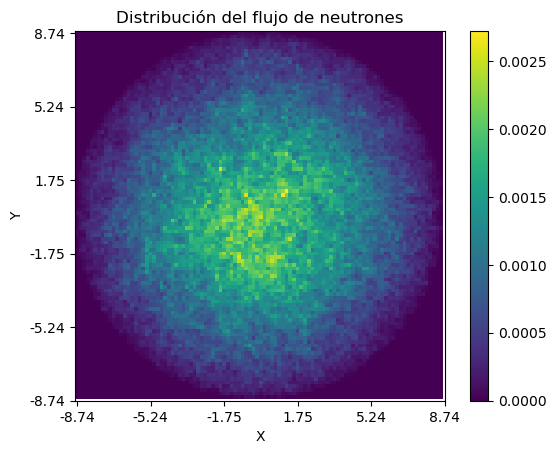

In [38]:
plt.imshow(flux_n_position.mean)
plt.colorbar()

plt.xlabel('X')
plt.ylabel('Y')
plt.xticks([0,20,40,60,80,100],[round(-R01,2),round((R01/50)*20-R01,2),round((R01/50)*40-R01,2),round((R01/50)*60-R01,2),round((R01/50)*80-R01,2),round((R01/50)*100-R01,2)])
plt.yticks([0,20,40,60,80,100],[-1*round(-R01,2),-1*round((R01/50)*20-R01,2),-1*round((R01/50)*40-R01,2),-1*round((R01/50)*60-R01,2),-1*round((R01/50)*80-R01,2),-1*round((R01/50)*100-R01,2)])
plt.title('Distribución del flujo de neutrones')

In [39]:
flux_p_position=sp.get_tally(name='flux_p_position')
print(flux_p_position)

Tally
	ID             =	9
	Name           =	flux_p_position
	Filters        =	MeshFilter, ParticleFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength


In [40]:
#flux_p_position.std_dev.shape = (100, 100)
flux_p_position.mean.shape = (100, 100)

Text(0.5, 1.0, 'Distribución del flujo de fotones')

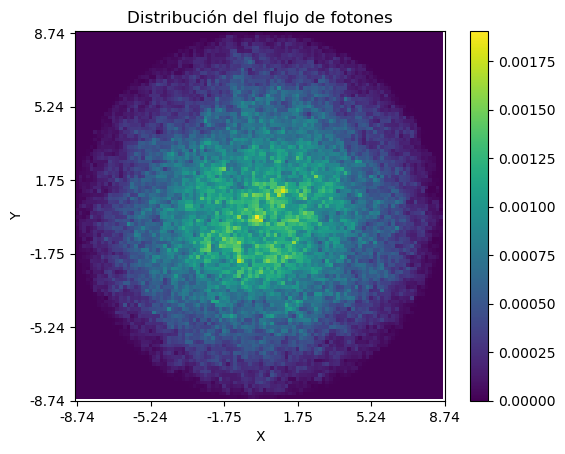

In [41]:
plt.imshow(flux_p_position.mean)
plt.colorbar()

plt.xlabel('X')
plt.ylabel('Y')
plt.xticks([0,20,40,60,80,100],[round(-R01,2),round((R01/50)*20-R01,2),round((R01/50)*40-R01,2),round((R01/50)*60-R01,2),round((R01/50)*80-R01,2),round((R01/50)*100-R01,2)])
plt.yticks([0,20,40,60,80,100],[-1*round(-R01,2),-1*round((R01/50)*20-R01,2),-1*round((R01/50)*40-R01,2),-1*round((R01/50)*60-R01,2),-1*round((R01/50)*80-R01,2),-1*round((R01/50)*100-R01,2)])
plt.title('Distribución del flujo de fotones')

In [42]:
flux_n_energy=sp.get_tally(name='flux_n_energy')
print(flux_n_energy)

Tally
	ID             =	10
	Name           =	flux_n_energy
	Filters        =	EnergyFilter, ParticleFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength


In [43]:
flux_n_energy.mean[:,0][:,0].shape

(200,)

\phi

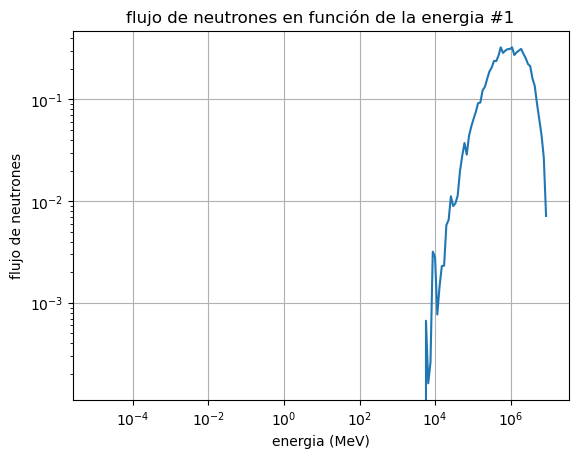

In [44]:
plt.loglog(energy_n[:-1], flux_n_energy.mean[:,0][:,0])

plt.xlabel('energia (MeV)')
plt.ylabel('flujo de neutrones')
plt.title('flujo de neutrones en función de la energia #1')
plt.grid()

plt.show()


In [45]:
flux_p_energy=sp.get_tally(name='flux_p_energy')
print(flux_p_energy)

Tally
	ID             =	11
	Name           =	flux_p_energy
	Filters        =	EnergyFilter, ParticleFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength


In [46]:
flux_p_energy.mean[:,0][:,0].shape

(200,)

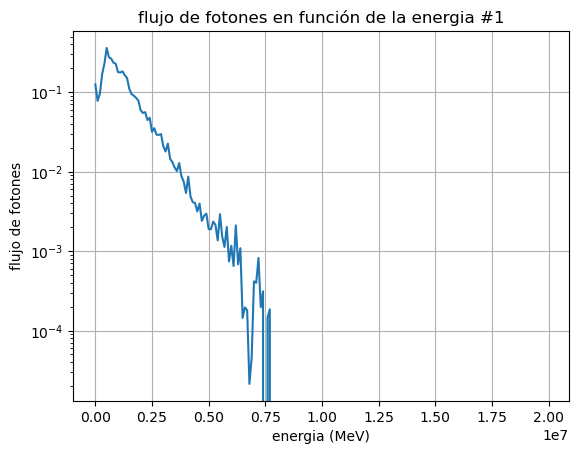

In [47]:
plt.semilogy(energy_p[:-1], flux_p_energy.mean[:,0][:,0])

plt.xlabel('energia (MeV)')
plt.ylabel('flujo de fotones')
plt.title('flujo de fotones en función de la energia #1')
plt.grid()

plt.show()

In [48]:
energy_n.shape

(201,)

In [49]:
flux_n_energy_a=sp.get_tally(name='flux_n_energy')

In [50]:
dV=(4/3)*np.pi*R01**3
data=sp.get_tally(name='flux_n_energy').get_pandas_dataframe(nuclides=False)
data.columns=['Emin','Emax','particle','score','mean','stdv']
Emin=data['Emin'].values
Emax=data['Emax'].values
dE=Emax-Emin
E_n=(Emin+Emax)/2.0

In [51]:
flux_n_energy_a.mean[:,0][:,0]=flux_n_energy.mean[:,0][:,0]/(dV*dE)

In [52]:
data_mean=data['mean']/(dE*dV)
data_stdv=data['stdv']/(dE*dV)

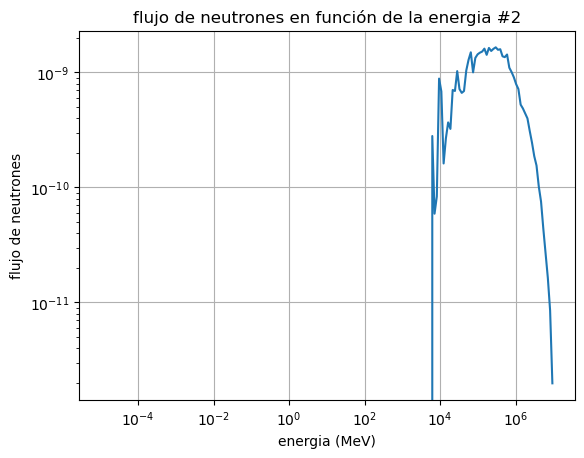

In [53]:
plt.loglog(E_n, data_mean)

plt.xlabel('energia (MeV)')
plt.ylabel('flujo de neutrones')
plt.title('flujo de neutrones en función de la energia #2')
plt.grid()

plt.show()

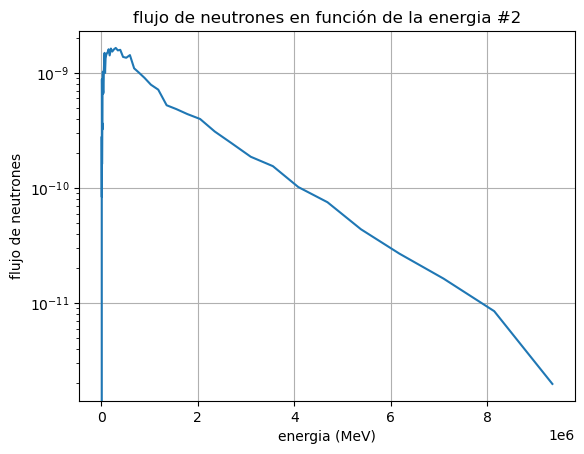

In [54]:
plt.semilogy(E_n, data_mean)

plt.xlabel('energia (MeV)')
plt.ylabel('flujo de neutrones')
plt.title('flujo de neutrones en función de la energia #2')
plt.grid()

plt.show()

In [55]:
flux_p_energy_a=sp.get_tally(name='flux_p_energy')

In [60]:
dV=(4/3)*np.pi*R01**3
data=sp.get_tally(name='flux_p_energy').get_pandas_dataframe(nuclides=False)
data.columns=['Emin','Emax','particle','score','mean','stdv']
Emin=data['Emin'].values
Emax=data['Emax'].values
dE=Emax-Emin
E_p=(Emin+Emax)/2.0

In [61]:
flux_p_energy_a.mean[:,0][:,0]=flux_n_energy.mean[:,0][:,0]/(dV*dE)

In [62]:
data_mean=data['mean']/(dE*dV)
data_stdv=data['stdv']/(dE*dV)

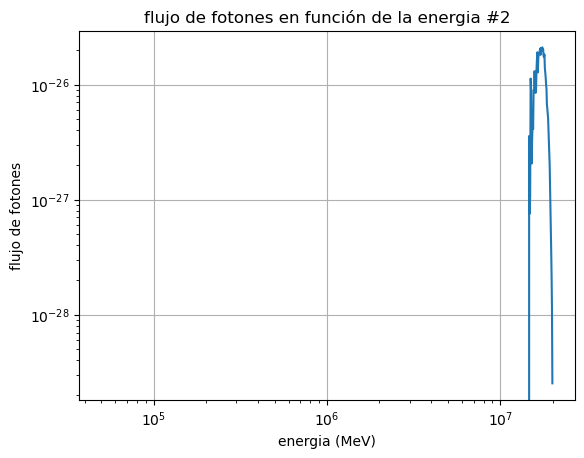

In [63]:
plt.loglog(E_p, data_mean)

plt.xlabel('energia (MeV)')
plt.ylabel('flujo de fotones')
plt.title('flujo de fotones en función de la energia #2')
plt.grid()

plt.show()

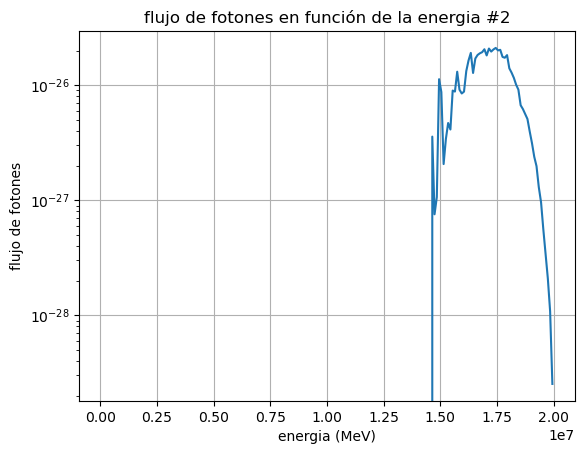

In [64]:
plt.semilogy(E_p, data_mean)

plt.xlabel('energia (MeV)')
plt.ylabel('flujo de fotones')
plt.title('flujo de fotones en función de la energia #2')
plt.grid()

plt.show()

## Observación de la precisión de los resultados de OpenMC en función del número de partículas simuladas.

In [65]:
sp1= openmc.StatePoint('statepoint.110.100.h5') 
sp2= openmc.StatePoint('statepoint.110.1000.h5') 
sp3= openmc.StatePoint('statepoint.110.10000.h5') 
sp4= openmc.StatePoint('statepoint.110.10500.h5')


In [66]:
sp1.keff


1.0188997058785665+/-0.007491097876379731

In [67]:
keff1=sp1.k_generation
keff2=sp2.k_generation
keff3=sp3.k_generation
keff4=sp4.k_generation

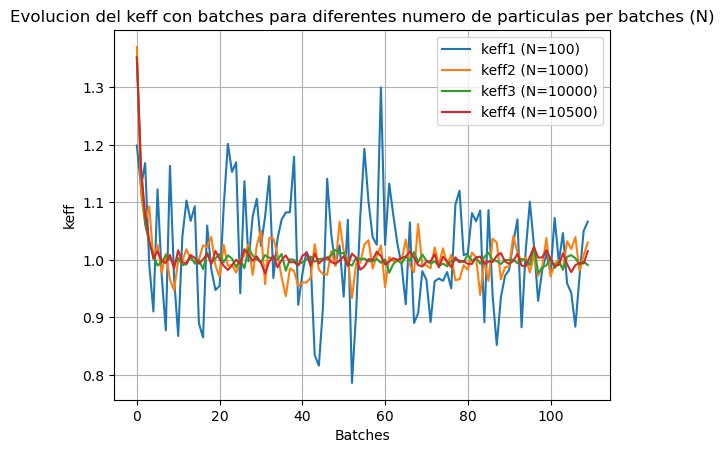

In [68]:
plt.plot(keff1,label="keff1 (N=100)")
plt.plot(keff2,label="keff2 (N=1000)")
plt.plot(keff3,label="keff3 (N=10000)")
plt.plot(keff4,label="keff4 (N=10500)")

plt.title("Evolucion del keff con batches para diferentes numero de particulas per batches (N)")

plt.xlabel('Batches')
plt.ylabel('keff')

plt.grid()

plt.legend()

plt.show()

In [69]:
leak = sp1.get_tally(name='leakage')
leak = leak.summation(filter_type=openmc.MeshSurfaceFilter, remove_filter=True)
print(leak)

Tally
	ID             =	15
	Name           =	
	Filters        =	
	Nuclides       =	total
	Scores         =	['current']
	Estimator      =	tracklength


In [70]:
fiss_rate = sp1.get_tally(name='fiss. rate')
abs_rate = sp1.get_tally(name='abs. rate')
print(leak.mean, fiss_rate.mean, abs_rate.mean)


[[[28.62715744]]] [[[1.01372075]]] [[[30.84109478]]]


In [71]:
keff = fiss_rate / (abs_rate + leak)
keff.get_pandas_dataframe()

,nuclide,score,mean,std. dev.
0,total,(nu-fission / (absorption + current)),0.017046,0.000181


In [72]:
leak.mean

array([[[28.62715744]]])

In [73]:
N=100*110

In [74]:
leak_total = leak.mean/N

In [75]:
leak_total

array([[[0.00260247]]])